## Gesture Recognition


### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

| Gesture | Corresponding Action |
| --- |--- |
| Thumbs Up | Increase the volume |
|Thumbs Down | Decrease the volume|
|Left Swipe | 'Jump' backwards 10 seconds|
|Right Swipe | 'Jump' forward 10 seconds|
|Stop | Pause the movie |


Each video is a sequence of 30 frames (or images)
### Objectives:
<ol>
<li>Generator: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

<li>Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

<li>Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.
</ol>

#### Case Study Group:
<ul>
<li>Rishi Rohra (Facilitator)
<li>Seema Simoliya
</ul>

In [2]:
#importing the necessary libraries

import numpy as np
import os
from imageio import imread
from cv2 import resize
import datetime
import os

In [3]:
# Setting the random seed so that the results won't differ.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
# common function to be used to plot the models
import matplotlib.pyplot as plt

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### Generator
The generator code is the most important part of the project. In this, we are going to take a batch of videos, resize and crop the images of the videos and then feed it to the model.

In [6]:
y=120
z=120
def my_generator(source_path, folder_list, batch_size):
    print("Generator")
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,len(img_idx),y,z,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[0] != image.shape[1]:
                        image = resize(image[0:120,10:150],(y,z)).astype(np.float32)
                    else:
                        image = resize(image,(y,z)).astype(np.float32)
                    #Normalization of Images                   
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,len(img_idx),y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[0] != image.shape[1]:
                        image = resize(image[0:120,10:150],(y,z)).astype(np.float32)
                    else:
                        image = resize(image,(y,z)).astype(np.float32)
                    #Normalization of Images                   
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [7]:
# Define where the data is stored
import pathlib
import glob

data_dir_train = "/datasets/Project_data/train"
data_dir_test = "/datasets/Project_data/val"

Experiment with the batch size. Initially setting the batch size to 10.

In [8]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())


## Base Conv3D model
Conv3D model with last layer as softmax. 

In [10]:
batch_size = 10
num_epochs = 30
print ('# batch size =', batch_size)
print ('# epochs =', num_epochs)

# batch size = 10
# epochs = 30


In [9]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [8]:
# input shape is (84,84,3)

model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

2023-01-10 23:44:21.413178: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-01-10 23:44:21.413258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [9]:
import keras
from keras import optimizers


#sgd = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
optmiser=tf.keras.optimizers.Adam()
model.compile(optimizer=optmiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 84, 84, 64)   256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 42, 84, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 42, 84, 128)   5

In [10]:
train_generator = my_generator(data_dir_train, train_doc, batch_size)
val_generator = my_generator(data_dir_test, val_doc, batch_size)

In [14]:
curr_dt_time = datetime.datetime.now()

#train_path = '/notebooks/storage/Final_data/Project_data/train'
#val_path = '/notebooks/storage/Final_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


In [12]:
model_dir = "dl_content/Upgrad DL/Gesture Recognition Assignment/"
model_name = model_dir + 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [14]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Generator
Source path =  /datasets/Project_data/train ; batch size = 10
Epoch 1/30


2023-01-10 23:44:41.467797: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 12.1687 - categorical_accuracy: 0.3333Generator
Source path =  /datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to dl_content/Upgrad DL/Gesture Recognition Assignment/model_init_2023-01-1023_44_33.053658/model-00001-12.16871-0.33333-144.69850-0.23000.h5
67/67 [==============================] - 40s 544ms/step - loss: 12.1687 - categorical_accuracy: 0.3333 - val_loss: 144.6985 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 3.4502 - categorical_accuracy: 0.3665
Epoch 00002: saving model to dl_content/Upgrad DL/Gesture Recognition Assignment/model_init_2023-01-1023_44_33.053658/model-00002-3.45018-0.36652-7.10859-0.30000.h5
67/67 [==============================] - 36s 538ms/step - loss: 3.4502 - categorical_accuracy: 0.3665 - val_loss: 7.1086 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ET

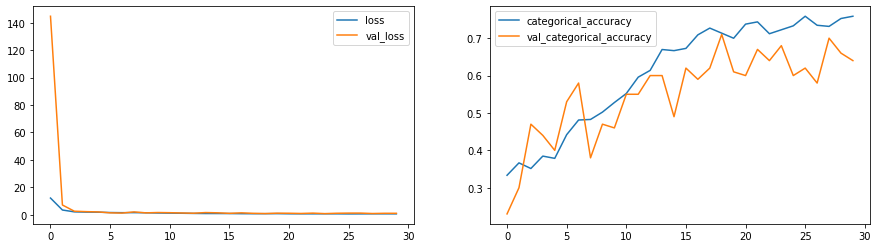

In [18]:
plot(history)

### Base Model +  batch_size =30, epochs =20

In [19]:
batch_size=30
num_epochs = 20

In [20]:
# input shape is (84,84,3)

model1 = Sequential()
model1.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model1.add(BatchNormalization())
model1.add(Activation('elu'))
model1.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model1.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('elu'))
model1.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model1.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('elu'))
model1.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model1.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('elu'))
model1.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(512, activation='elu'))
model1.add(Dropout(0.5))
model1.add(Dense(5, activation='softmax'))

In [21]:
optmiser=tf.keras.optimizers.Adam()
model1.compile(optimizer=optmiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization_4 (Batc  (None, 18, 84, 84, 64)   256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 42, 84, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_5 (Batc  (None, 9, 42, 84, 128)  

In [22]:
model_dir = "dl_content/Upgrad DL/Gesture Recognition Assignment/"
model_name = model_dir + 'model1_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print(model_name)
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model1-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]

dl_content/Upgrad DL/Gesture Recognition Assignment/model1_init_2023-01-1023_44_33.053658/


In [23]:
train_generator = my_generator(data_dir_train, train_doc, batch_size)
val_generator = my_generator(data_dir_test, val_doc, batch_size)

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [25]:
history=model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Generator
Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/20
22/23 [===========================>..] - ETA: 1s - loss: 14.1352 - categorical_accuracy: 0.3136Generator
Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to dl_content/Upgrad DL/Gesture Recognition Assignment/model1_init_2023-01-1023_44_33.053658/model1-00001-14.11259-0.31222-1059.46558-0.23000.h5
23/23 [==============================] - 40s 2s/step - loss: 14.1126 - categorical_accuracy: 0.3122 - val_loss: 1059.4656 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
22/23 [===========================>..] - ETA: 1s - loss: 2.4823 - categorical_accuracy: 0.3848
Epoch 00002: saving model to dl_content/Upgrad DL/Gesture Recognition Assignment/model1_init_2023-01-1023_44_33.053658/model1-00002-2.47448-0.38612-104.29612-0.21000.h5
23/23 [==============================] - 35s 2s/step - loss: 2.4745 - categorical_accuracy: 0.3861 - val_loss: 104.2961 - val_categoric

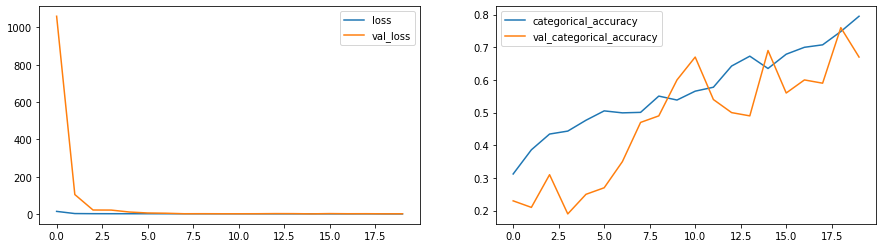

In [26]:
plot(history)

## Model 2
Adding droupout layers in the base model and changing the optimizer to SGD. Keeping batch_size and # epochs same. 

In [27]:
batch_size=20
num_epochs = 30

In [28]:
# input shape is (84,84,3)

model2 = Sequential()
model2.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model2.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model2.add(Dropout(0.25))

model2.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model2.add(Dropout(0.25))

model2.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(512, activation='elu'))
model2.add(Dropout(0.5))
model2.add(Dense(5, activation='softmax'))

In [29]:
sgd=tf.keras.optimizers.SGD()
model2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization_8 (Batc  (None, 18, 84, 84, 64)   256       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 42, 84, 64)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_9 (Batc  (None, 9, 42, 84, 128)  

In [30]:
model_dir = "dl_content/Upgrad DL/Gesture Recognition Assignment/"
model_name =model_dir +  'model2_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print(model_name)
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model2-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]

dl_content/Upgrad DL/Gesture Recognition Assignment/model2_init_2023-01-1023_44_33.053658/


In [31]:
train_generator = my_generator(data_dir_train, train_doc, batch_size)
val_generator = my_generator(data_dir_test, val_doc, batch_size)

In [32]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
history=model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Generator
Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/30
33/34 [============================>.] - ETA: 0s - loss: 6.2918 - categorical_accuracy: 0.2924Generator
Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to dl_content/Upgrad DL/Gesture Recognition Assignment/model2_init_2023-01-1023_44_33.053658/model2-00001-6.27428-0.29110-3.62702-0.31000.h5
34/34 [==============================] - 38s 1s/step - loss: 6.2743 - categorical_accuracy: 0.2911 - val_loss: 3.6270 - val_categorical_accuracy: 0.3100 - lr: 0.0100
Epoch 2/30
33/34 [============================>.] - ETA: 0s - loss: 1.9558 - categorical_accuracy: 0.3606
Epoch 00002: saving model to dl_content/Upgrad DL/Gesture Recognition Assignment/model2_init_2023-01-1023_44_33.053658/model2-00002-1.95290-0.36048-5.52848-0.20000.h5
34/34 [==============================] - 34s 1s/step - loss: 1.9529 - categorical_accuracy: 0.3605 - val_loss: 5.5285 - val_categorical_accuracy: 

### With the above three experiments we understand that there is not much effect on the accuracy if we change the number of epochs, batch size, droup out layers or even tuning hyperparameter. Lets change the image resolution to see if it has any impact on the Conv3D model's accuracy.

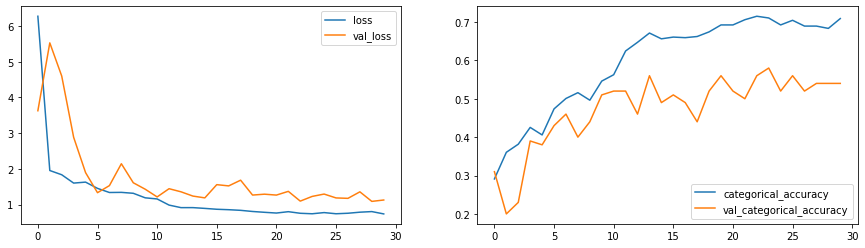

In [34]:
plot(history)

## Model 3
Changing the input image resolution. take image size as (100,100,3) and number of images in a video as 20.

In [7]:
batch_size=30
num_epochs = 30

In [10]:
model2 = Sequential()
model2.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(20,100,100,3)))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model2.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model2.add(Dropout(0.25))

model2.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model2.add(Dropout(0.25))

model2.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(512, activation='elu'))
model2.add(Dropout(0.5))
model2.add(Dense(5, activation='softmax'))

2023-01-11 04:43:18.488315: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-01-11 04:43:18.488382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


In [11]:
adm=tf.keras.optimizers.Adam()
model2.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 100, 100, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 20, 100, 100, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 100, 100, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 50, 100, 64)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 50, 100, 128)  221312    
                                                                 
 batch_normalization_1 (Batc  (None, 10, 50, 100, 128)  

In [14]:
model_name = 'model3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print(model_name)
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model2-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]

model3_init_2023-01-1104_43_47.711408/


In [26]:
train_generator = my_generator(data_dir_train, train_doc, batch_size)
val_generator = my_generator(data_dir_test, val_doc, batch_size)

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [27]:
history=model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Generator
Source path =  /datasets/Project_data/train ; batch size = 30
Epoch 1/30


2023-01-11 04:49:50.390090: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 21.1800 - categorical_accuracy: 0.2564Generator
Source path =  /datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model3_init_2023-01-1104_43_47.711408/model2-00001-21.17996-0.25641-207.53621-0.28000.h5
23/23 [==============================] - 50s 2s/step - loss: 21.1800 - categorical_accuracy: 0.2564 - val_loss: 207.5362 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 4.8337 - categorical_accuracy: 0.3469
Epoch 00002: saving model to model3_init_2023-01-1104_43_47.711408/model2-00002-4.83369-0.34691-27.20810-0.21000.h5
23/23 [==============================] - 40s 2s/step - loss: 4.8337 - categorical_accuracy: 0.3469 - val_loss: 27.2081 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 2.2616 - categorical_accuracy: 0.3756
Epoch 00003: saving model to model3_init_2023-01-110

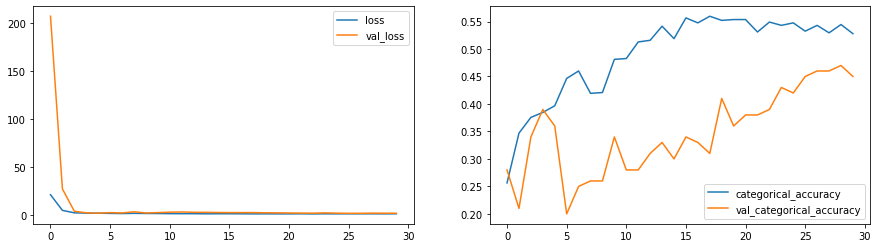

In [29]:
plot(history)

## Model 4
Changing the input image resolution. take image size as (120,120,3) and number of images in a video as 16.

In [30]:
batch_size=20
num_epochs = 30

In [31]:
model3 = Sequential()
model3.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(16,120,120,3)))
model3.add(BatchNormalization())
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model3.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model3.add(Dropout(0.25))

model3.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model3.add(Dropout(0.25))

model3.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(512, activation='elu'))
model3.add(Dropout(0.5))
model3.add(Dense(5, activation='softmax'))

In [33]:
adm=tf.keras.optimizers.Adam()
model3.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 64)  5248      
                                                                 
 batch_normalization_4 (Batc  (None, 16, 120, 120, 64)  256      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 64)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 120, 64)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 120, 128)   221312    
                                                                 
 batch_normalization_5 (Batc  (None, 8, 60, 120, 128) 

In [34]:
model_name = 'model3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print(model_name)
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model3-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]

model3_init_2023-01-1104_43_47.711408/


In [35]:
train_generator = my_generator(data_dir_train, train_doc, batch_size)
val_generator = my_generator(data_dir_test, val_doc, batch_size)

In [36]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [37]:
history=model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Generator
Source path =  /datasets/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 22.4132 - categorical_accuracy: 0.3243Generator
Source path =  /datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model3_init_2023-01-1104_43_47.711408/model3-00001-22.41316-0.32428-45.33709-0.17000.h5
34/34 [==============================] - 54s 1s/step - loss: 22.4132 - categorical_accuracy: 0.3243 - val_loss: 45.3371 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 3.0429 - categorical_accuracy: 0.4389
Epoch 00002: saving model to model3_init_2023-01-1104_43_47.711408/model3-00002-3.04293-0.43891-6.02142-0.30000.h5
34/34 [==============================] - 42s 1s/step - loss: 3.0429 - categorical_accuracy: 0.4389 - val_loss: 6.0214 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.6243 - ca

In [ ]:
plot(history)

## RNN Model with LSTM Cell

In [29]:
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM

filtersizeRNN = (2,2)
lstm_cells =64
dense_neurons=64
dropout=0.25
 
model_lstm = Sequential()
model_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                              input_shape=(18,120,120,3)))
model_lstm.add(TimeDistributed(BatchNormalization()))
model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
    
model_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_lstm.add(TimeDistributed(BatchNormalization()))
model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
    
model_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_lstm.add(TimeDistributed(BatchNormalization()))
model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
    
model_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_lstm.add(TimeDistributed(BatchNormalization()))
model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
    
model_lstm.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_lstm.add(TimeDistributed(BatchNormalization()))
model_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
model_lstm.add(TimeDistributed(Flatten()))
model_lstm.add(LSTM(lstm_cells))
model_lstm.add(Dropout(dropout))
    
model_lstm.add(Dense(dense_neurons,activation='relu'))
model_lstm.add(Dropout(dropout))
    
model_lstm.add(Dense(5, activation='softmax'))
optimiser = tf.keras.optimizers.Adam(learning_rate=0.00004)
model_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [30]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 18, 60, 60, 32)  

In [31]:

model_lstm_name = 'model_lstm_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_lstm_name):
    os.mkdir(model_lstm_name)
        
filepath = model_lstm_name + 'model_lstm-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [32]:
train_generator = my_generator(data_dir_train, train_doc, batch_size)
val_generator = my_generator(data_dir_test, val_doc, batch_size)

In [33]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [34]:
history_lstm=model_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator, callbacks=callbacks_list, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Generator
Source path =  /datasets/Project_data/train ; batch size = 10
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.6508 - categorical_accuracy: 0.2549Generator
Source path =  /datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_lstm_init_2023-01-1105_48_56.500809/model_lstm-00001-1.65079-0.25490-1.67461-0.21000.h5
67/67 [==============================] - 44s 617ms/step - loss: 1.6508 - categorical_accuracy: 0.2549 - val_loss: 1.6746 - val_categorical_accuracy: 0.2100 - lr: 4.0000e-05
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.4559 - categorical_accuracy: 0.3710
Epoch 00002: saving model to model_lstm_init_2023-01-1105_48_56.500809/model_lstm-00002-1.45593-0.37104-1.72726-0.20000.h5
67/67 [==============================] - 40s 603ms/step - loss: 1.4559 - categorical_accuracy: 0.3710 - val_loss: 1.7273 - val_categorical_accuracy: 0.2000 - lr: 4.0000e-05
Epoch 3/30
67/67 [==============================] - ET

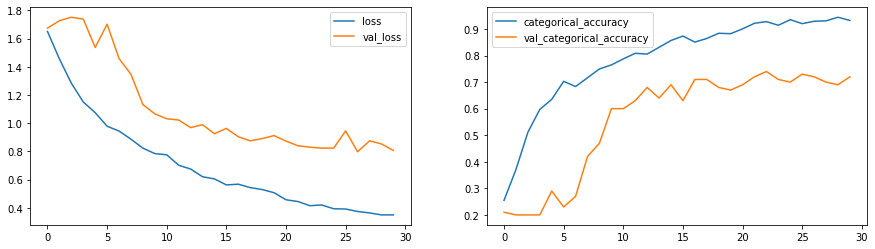

In [35]:
plot(history_lstm)

The above model is a better model then Conv3D. training accuracy is 93% and 
We can use data Augmentation and pretrained model with GRU to further experiment the performance.